In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.75 # fraction plucked that becomes coarse
theta = 0.75 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 10
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 2000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

20000000.0


In [7]:
np.round(Eb, 4)

array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.    ])

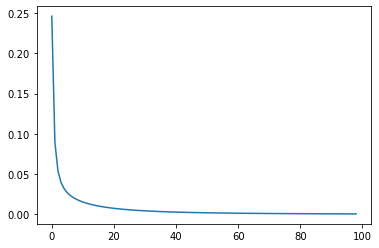

In [8]:
plt.plot(S)

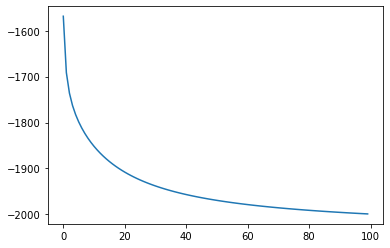

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.000695372386883264

In [11]:
eta

array([-1568.22950379, -1691.28105587, -1736.03568429, -1762.87584586,
       -1782.59887543, -1798.50409554, -1811.9713282 , -1823.7051935 ,
       -1834.11790673, -1843.47529213, -1851.96160423, -1859.71173678,
       -1866.8286876 , -1873.39371627, -1879.47260318, -1885.11969837,
       -1890.38065167, -1895.2943206 , -1899.89414588, -1904.20917017,
       -1908.26481072, -1912.08345762, -1915.68494537, -1919.08693063,
       -1922.30519889, -1925.35391662, -1928.24584076, -1930.99249432,
       -1933.60431496, -1936.09078146, -1938.46052226, -1940.72140898,
       -1942.8806375 , -1944.94479865, -1946.91993997, -1948.81161998,
       -1950.624956  , -1952.36466642, -1954.03510818, -1955.64031014,
       -1957.18400279, -1958.66964479, -1960.10044679, -1961.47939278,
       -1962.80925929, -1964.09263272, -1965.33192496, -1966.52938751,
       -1967.68712431, -1968.80710331, -1969.89116707, -1970.94104233,
       -1971.95834879, -1972.94460703, -1973.90124588, -1974.82960902,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([4.31170496e+02, 3.08118944e+02, 2.63364316e+02, 2.36524154e+02,
       2.16801125e+02, 2.00895904e+02, 1.87428672e+02, 1.75694806e+02,
       1.65282093e+02, 1.55924708e+02, 1.47438396e+02, 1.39688263e+02,
       1.32571312e+02, 1.26006284e+02, 1.19927397e+02, 1.14280302e+02,
       1.09019348e+02, 1.04105679e+02, 9.95058541e+01, 9.51908298e+01,
       9.11351892e+01, 8.73165423e+01, 8.37150546e+01, 8.03130693e+01,
       7.70948011e+01, 7.40460833e+01, 7.11541592e+01, 6.84075056e+01,
       6.57956850e+01, 6.33092185e+01, 6.09394777e+01, 5.86785910e+01,
       5.65193625e+01, 5.44552013e+01, 5.24800600e+01, 5.05883800e+01,
       4.87750440e+01, 4.70353335e+01, 4.53648918e+01, 4.37596898e+01,
       4.22159972e+01, 4.07303552e+01, 3.92995532e+01, 3.79206072e+01,
       3.65907407e+01, 3.53073672e+01, 3.40680750e+01, 3.28706124e+01,
       3.17128757e+01, 3.05928967e+01, 2.95088329e+01, 2.84589576e+01,
       2.74416512e+01, 2.64553929e+01, 2.54987541e+01, 2.45703909e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_16.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_16.csv', alpha, delimiter = ',')

In [15]:
Eh

array([ 5.11080995e-19, -5.23609311e-14, -3.58623199e-14, -2.44075223e-14,
       -1.77881130e-14, -1.30416918e-14, -9.37833781e-15, -5.45939046e-15,
       -6.53848535e-15, -4.21608898e-15, -3.67550271e-15, -2.74506197e-15,
       -1.41625240e-15, -5.75698485e-16, -1.47803628e-15, -1.31701017e-15,
       -9.85109099e-16, -6.66057283e-16, -4.90695550e-16, -2.60954549e-16,
       -5.86459783e-16,  1.72082809e-16, -2.72305706e-16, -2.12209958e-16,
       -1.86231086e-16,  7.54259357e-17, -4.07135565e-16,  2.57007215e-16,
       -3.22751645e-16,  2.40761684e-16, -7.65461498e-17, -1.43359723e-16,
        3.01610161e-17, -1.47248620e-16,  4.58614351e-16, -6.92717105e-16,
        4.25219032e-16, -8.79301152e-17,  1.14395096e-16,  2.17893963e-16,
       -7.36159614e-16,  4.17481125e-16, -2.57268944e-17,  3.54488233e-16,
       -7.37416969e-16,  3.68400320e-16,  3.88602022e-16, -8.02353619e-16,
        3.84851545e-16,  2.33232312e-17,  2.82660220e-17,  1.78802897e-16,
       -5.13716982e-16,  